In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from chesswinnerprediction.constants import PROCESSED_FOLDER_PATH
from chesswinnerprediction.baseline.utils import (
    get_x_and_y,
    get_class_weights,
    estimate_baseline_model,
    transform_and_scale_df,
)

In [3]:
data_dir = "lichess_db_standard_rated_2017-05"
data_path = os.path.join(PROCESSED_FOLDER_PATH, data_dir)

In [4]:
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(data_path, "valid.csv"))

In [5]:
train_df.head()

,Event,WhiteElo,BlackElo,TimeControl,Result,Termination,ECO,White,Black,EloDiff,MeanElo,BaseTime,IncrementTime,ZeroIncrementTime,ResultEncoded,WhiteWin,BlackWin,Draw,times_in_second,GameDuration
0,Rated Bullet tournament,1425,1516,30+0,1-0,Time forfeit,A46,luptatoarea,PawnSean,-91,1470.5,30,0,1,1,1,0,0,"[30, 30, 29, 30, 28, 30, 28, 30, 27, 30, 26, 3...",56
1,Rated Blitz game,1573,1612,180+0,0-1,Normal,C40,Tregart,mostar,-39,1592.5,180,0,1,0,0,1,0,"[180, 180, 179, 178, 175, 174, 175, 173, 166, ...",210
2,Rated Bullet tournament,1643,1679,60+0,0-1,Normal,A20,CAMPOMANES,selobiyo,-36,1661.0,60,0,1,0,0,1,0,"[60, 60, 59, 59, 59, 59, 58, 59, 57, 58, 56, 5...",56
3,Rated Blitz game,1596,1572,180+2,1-0,Normal,B13,leo_E232,theonionknight,24,1584.0,180,2,0,1,1,0,0,"[180, 180, 181, 182, 181, 180, 181, 180, 179, ...",426
4,Rated UltraBullet tournament,1354,1367,15+0,0-1,Time forfeit,B15,eugenia,juanfer90,-13,1360.5,15,0,1,0,0,1,0,"[15, 15, 15, 15, 15, 15, 14, 14, 13, 13, 13, 1...",26


In [6]:
std_scaler = StandardScaler()
train_data = transform_and_scale_df(train_df, std_scaler)
valid_data = transform_and_scale_df(valid_df, std_scaler, fit_scale=False)

In [7]:
X_train, y_train = get_x_and_y(train_data, predict_draws=True)
X_valid, y_valid = get_x_and_y(valid_data, predict_draws=True)

class_weight = get_class_weights(y_train)

## Apply the Decision Tree Classifier

In [8]:
tree_clf = DecisionTreeClassifier(max_depth=10, class_weight=class_weight)
tree_clf = tree_clf.fit(X_train, y_train)

log loss on test data: 1.0591210986204416

                         Train Report                                      Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.58      0.48      0.53    378005              0.58      0.48      0.52     45215
         1-0       0.63      0.35      0.45    392248              0.63      0.35      0.45     47511
     1/2-1/2       0.05      0.62      0.09     20431              0.05      0.56      0.08      2537
    accuracy                           0.42    790684                                  0.42     95263
   macro avg       0.42      0.48      0.35    790684              0.42      0.46      0.35     95263
weighted avg       0.59      0.42      0.48    790684              0.59      0.42      0.47     95263
       


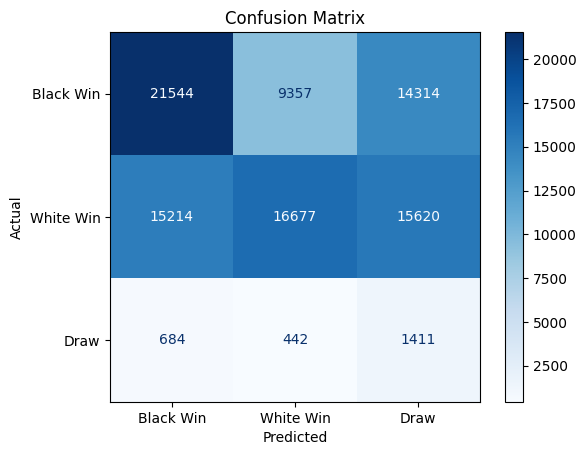

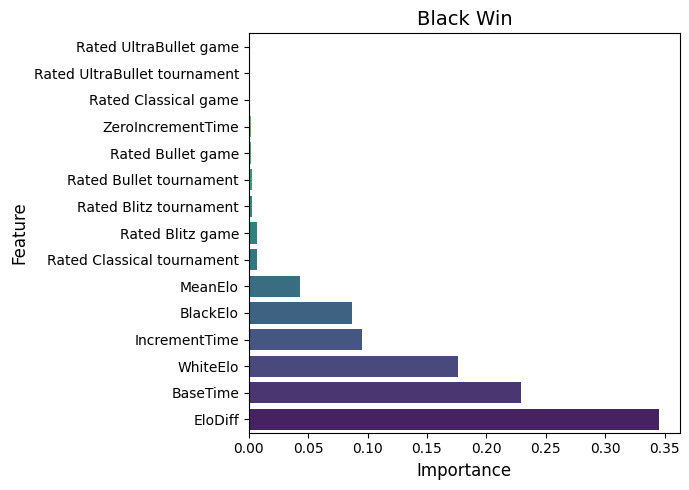

In [13]:
feature_importance = tree_clf.feature_importances_.reshape(1, -1)
estimate_baseline_model(
    tree_clf, feature_importance, X_train, y_train, X_valid, y_valid
)

## Apply the Random Forest Classifier

In [10]:
forest_clf = RandomForestClassifier(
    class_weight=class_weight, n_estimators=40, max_depth=11, n_jobs=-1
)
forest_clf = forest_clf.fit(X_train, y_train)

log loss on test data: 1.0114175559454135

                         Train Report                                      Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.61      0.43      0.51    378005              0.60      0.43      0.50     45215
         1-0       0.62      0.45      0.52    392248              0.61      0.45      0.52     47511
     1/2-1/2       0.05      0.61      0.10     20431              0.05      0.53      0.09      2537
    accuracy                           0.45    790684                                  0.44     95263
   macro avg       0.43      0.50      0.37    790684              0.42      0.47      0.37     95263
weighted avg       0.60      0.45      0.50    790684              0.59      0.44      0.50     95263
       


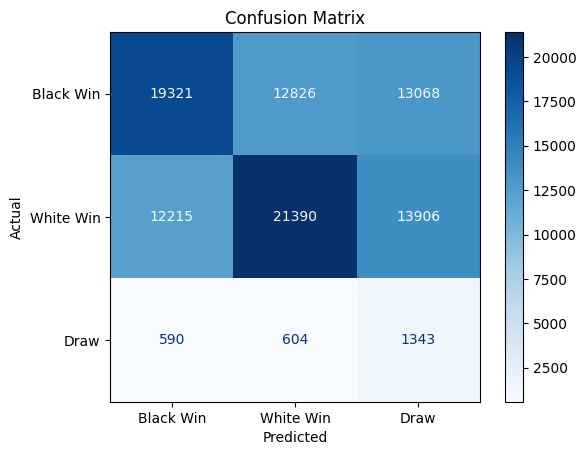

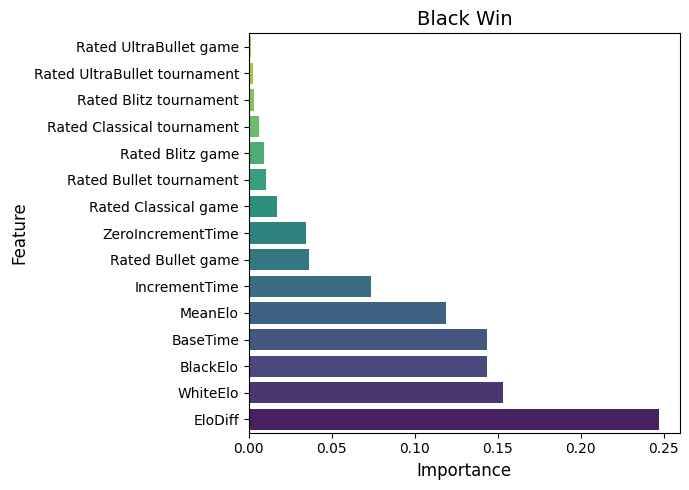

In [12]:
feature_importance = forest_clf.feature_importances_.reshape(1, -1)
estimate_baseline_model(
    forest_clf, feature_importance, X_train, y_train, X_valid, y_valid
)